In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

## Tasks 1 and 2 

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

#os.chdir("/content/gdrive/My Drive/") 
#!ls

data_dir = '/content/gdrive/My Drive/Assignment 5 Dataset/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [17]:
# Define transforms for the training data and testing data

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + 'train', transform = train_transforms)
valid_data = datasets.ImageFolder(data_dir + 'validation', transform = valid_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 16, shuffle = True)  # 16, 24, 32, 128?
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 16, shuffle = True)  # 16, 24, 32, 128?

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


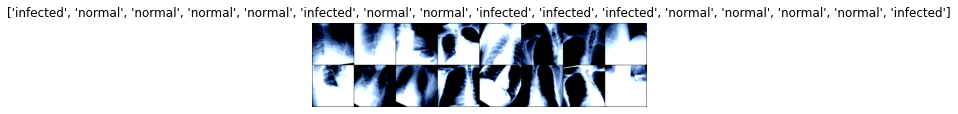

In [18]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [9]:
# Load the pretrained models from pytorch

vgg16 = models.vgg16(pretrained = True)

resnet18 = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


### A) VGG16 

In [55]:
# Freezing the layers:

def freezevgg16(layernum): # works for 2, extend for more? - Done.            
    if layernum != 1:
        i = 0
        for param in vgg16.features.parameters():
            i = i + 1
        layersizeuf = i - layernum 

        j = 0
        for param in vgg16.features.parameters():
            if layersizeuf > j:
                param.require_grad = False                        
            j = j + 1
            
    if layernum == 1:
        for param in vgg16.features.parameters():
            param.require_grad = False
        
Epochs = int(input("\nEnter number of epochs: ")) #10

learningrate = float(input("\nEnter learning rate: ")) #0.001

criterion = nn.CrossEntropyLoss()

freezeask = input("\nDo you want to freeze any layers? Answer with 'Yes' or 'No' to proceed: ")  

if (freezeask == "Yes"):
  layernum = int(input("\nEnter number of layers to freeze (1 to freeze all layers, other than 1 for exception of freezing layers): "))
  freezevgg16(layernum)
else:
  pass

num_features = vgg16.classifier[0].in_features

features = []

features.extend([nn.Linear(num_features, 440)])       # (34 * 10) + 100
features.extend([nn.Linear(440, len(class_names))])   # (34 * 10) + 100

vgg16.classifier = nn.Sequential(*features)

optimizer = optim.SGD(vgg16.parameters(), lr = learningrate, momentum = 0.9)


Enter number of epochs: 2

Enter learning rate: 0.0001

Do you want to freeze any layers? Answer with 'Yes' or 'No' to proceed: No


### VGG16 - Training 

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

errors = []

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg16(inputs)             #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        errors.append(loss.item())

        
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')

print('\nFinished Training')

Streaming output truncated to the last 5000 lines.
Train Epoch: 0 [10672/12000 (89%)]	Loss: 0.129396: : 667it [07:30,  1.48it/s]


Train Epoch: 0 [10672/12000 (89%)]	Loss: 0.129396: : 668it [07:30,  1.48it/s]


Train Epoch: 0 [10688/12000 (89%)]	Loss: 0.102036: : 668it [07:31,  1.48it/s]


Train Epoch: 0 [10688/12000 (89%)]	Loss: 0.102036: : 669it [07:31,  1.49it/s]


Train Epoch: 0 [10704/12000 (89%)]	Loss: 0.157498: : 669it [07:32,  1.49it/s]


Train Epoch: 0 [10704/12000 (89%)]	Loss: 0.157498: : 670it [07:32,  1.49it/s]


Train Epoch: 0 [10720/12000 (89%)]	Loss: 0.246078: : 670it [07:32,  1.49it/s]


Train Epoch: 0 [10720/12000 (89%)]	Loss: 0.246078: : 671it [07:32,  1.48it/s]


Train Epoch: 0 [10736/12000 (89%)]	Loss: 0.070788: : 671it [07:33,  1.48it/s]


Train Epoch: 0 [10736/12000 (89%)]	Loss: 0.070788: : 672it [07:33,  1.49it/s]


Train Epoch: 0 [10752/12000 (90%)]	Loss: 0.125491: : 672it [07:34,  1.49it/s]


Train Epoch: 0 [10752/12000 (90%)]	Loss: 0.125491: : 673it [07:34,  1


Finished Training


Text(0.5, 0, 'Epochs')

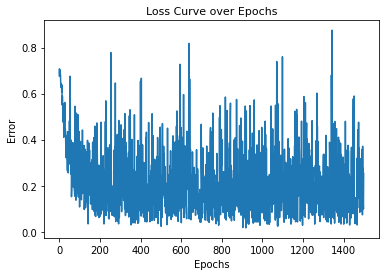

In [57]:
# Loss Curve - VGG16:

plt.plot(errors)
plt.title("Loss Curve over Epochs", fontsize = 11)
plt.ylabel('Error')
plt.xlabel('Epochs')

### VGG16 - Testing 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


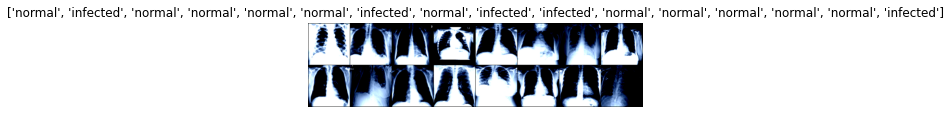

Predicted:  infected infected normal normal normal infected infected normal infected infected normal normal infected normal normal infected
Ground Truth:  normal infected normal normal normal normal infected normal infected infected normal normal normal normal normal infected

Final Accuracy of the network on the test images: 91 %

Confusion Matrix of the network on the test images: 
 tensor([[535.,  80.],
        [ 50., 835.]])

F1 Score of the network on the test images: 
 89.17


In [58]:
confusion_matrix = torch.zeros(2, 2) # 2 represents number of classes.

dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

correct = 0
total = 0
accuracies = []

with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        tempaccuracy = 100 * (correct / total)
        accuracies.append(tempaccuracy)

        for i, j in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[i, j] = confusion_matrix[i, j] + 1

print('\nFinal Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

# Confusion matrix
print('\nConfusion Matrix of the network on the test images: \n', confusion_matrix)

# F1 Score
tp = int(confusion_matrix[0, 0])
fn = int(confusion_matrix[0, 1])
fp = int(confusion_matrix[1, 0])
tn = int(confusion_matrix[1, 1])

precision = tp / (tp + fp)
recall = tp / (tp + fn)

f1score = round(100 * (2 * (recall * precision) / (recall + precision)), 2)

print('\nF1 Score of the network on the test images: \n', f1score)

Text(0.5, 0, 'Epochs')

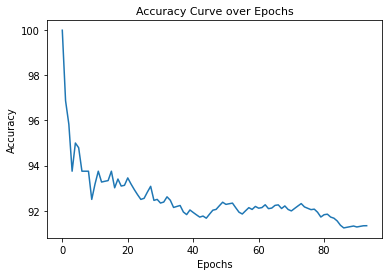

In [59]:
# Accuracy Curve - VGG16:

plt.plot(accuracies)
plt.title("Accuracy Curve over Epochs", fontsize = 11)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

### B) RESNET18 

In [61]:
# Freezing the layers:

def freezeresnet18(layernum): # works for 2, extend for more? - Done.
    if layernum != 1:
        i = 0
        for param in resnet18.parameters():
            i = i + 1
        layersizeuf = i - layernum 

        j = 0
        for param in resnet18.parameters():
            if layersizeuf > j:
                param.require_grad = False                        
            j = j + 1   
            
    if layernum == 1:
        for param in resnet18.parameters():
            param.require_grad = False
            
    
Epochs = int(input("\nEnter number of epochs: ")) #10

learningrate = float(input("\nEnter learning rate: ")) #0.001

criterion = nn.CrossEntropyLoss()

freezeask = input("\nDo you want to freeze any layers? Answer with 'Yes' or 'No' to proceed: ")  

if (freezeask == "Yes"):
  layernum = int(input("\nEnter number of layers to freeze (1 to freeze all layers, other than 1 for exception of freezing layers): "))
  freezeresnet18(layernum)
else:
  pass

num_features = resnet18.fc.in_features

features = []

features.extend([nn.Linear(num_features, 440)])       # (34 * 10) + 100
features.extend([nn.Linear(440, len(class_names))])   # (34 * 10) + 100

resnet18.classifier = nn.Sequential(*features)

optimizer = optim.SGD(resnet18.parameters(), lr = learningrate, momentum = 0.9)


Enter number of epochs: 2

Enter learning rate: 0.0001

Do you want to freeze any layers? Answer with 'Yes' or 'No' to proceed: No


### RESNET18 - Training 

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

errors = []

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet18(inputs)             #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        errors.append(loss.item())
        
    torch.save(resnet18.state_dict(), 'resnet18_ft.pth')

print('\nFinished Training')

Streaming output truncated to the last 5000 lines.
Train Epoch: 0 [10672/12000 (89%)]	Loss: 0.174270: : 667it [04:53,  2.22it/s]


Train Epoch: 0 [10672/12000 (89%)]	Loss: 0.174270: : 668it [04:53,  2.28it/s]


Train Epoch: 0 [10688/12000 (89%)]	Loss: 0.128793: : 668it [04:53,  2.28it/s]


Train Epoch: 0 [10688/12000 (89%)]	Loss: 0.128793: : 669it [04:53,  2.29it/s]


Train Epoch: 0 [10704/12000 (89%)]	Loss: 0.124545: : 669it [04:53,  2.29it/s]


Train Epoch: 0 [10704/12000 (89%)]	Loss: 0.124545: : 670it [04:53,  2.29it/s]


Train Epoch: 0 [10720/12000 (89%)]	Loss: 0.217842: : 670it [04:54,  2.29it/s]


Train Epoch: 0 [10720/12000 (89%)]	Loss: 0.217842: : 671it [04:54,  2.31it/s]


Train Epoch: 0 [10736/12000 (89%)]	Loss: 0.187463: : 671it [04:54,  2.31it/s]


Train Epoch: 0 [10736/12000 (89%)]	Loss: 0.187463: : 672it [04:54,  2.35it/s]


Train Epoch: 0 [10752/12000 (90%)]	Loss: 0.352046: : 672it [04:55,  2.35it/s]


Train Epoch: 0 [10752/12000 (90%)]	Loss: 0.352046: : 673it [04:55,  2


Finished Training


Text(0.5, 0, 'Epochs')

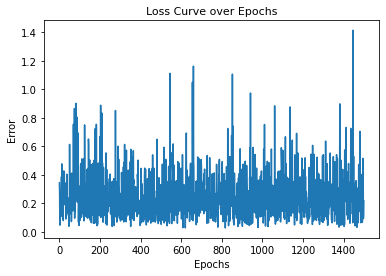

In [63]:
# Loss Curve - RESNET18:

plt.plot(errors)
plt.title("Loss Curve over Epochs", fontsize = 11)
plt.ylabel('Error')
plt.xlabel('Epochs')

### RESNET18 - Testing 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


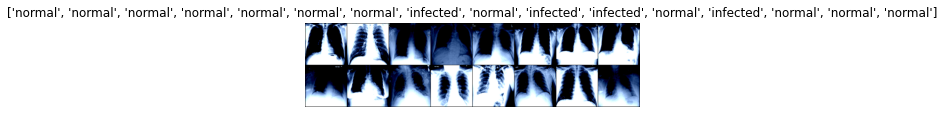

Predicted:  normal normal normal normal normal normal normal infected infected infected infected normal infected normal normal normal
Ground Truth:  normal normal normal normal normal normal normal infected normal infected infected normal infected normal normal normal

Final Accuracy of the network on the test images: 90 %

Confusion Matrix of the network on the test images: 
 tensor([[539.,  76.],
        [ 70., 815.]])

F1 Score of the network on the test images: 
 88.07


In [64]:
confusion_matrix = torch.zeros(2, 2) # 2 represents number of classes.

dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

images, labels = images.to(device), labels.to(device)    #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

correct = 0
total = 0
accuracies = []

with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        tempaccuracy = 100 * (correct / total)
        accuracies.append(tempaccuracy)
        
        for i, j in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[i, j] += 1

print('\nFinal Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

# Confusion matrix
print('\nConfusion Matrix of the network on the test images: \n', confusion_matrix)

# F1 Score
tp = int(confusion_matrix[0, 0])
fn = int(confusion_matrix[0, 1])
fp = int(confusion_matrix[1, 0])
tn = int(confusion_matrix[1, 1])

precision = tp / (tp + fp)
recall = tp / (tp + fn)

f1score = round(100 * (2 * (recall * precision) / (recall + precision)), 2)

print('\nF1 Score of the network on the test images: \n', f1score)

Text(0.5, 0, 'Epochs')

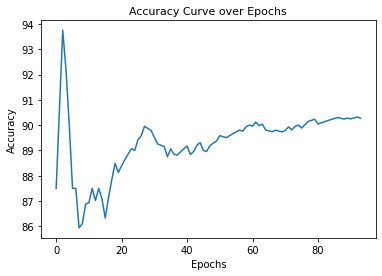

In [65]:
# Accuracy Curve - RESNET18:

plt.plot(accuracies)
plt.title("Accuracy Curve over Epochs", fontsize = 11)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')